## AR Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

In this case an AR(1) model is used.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

np.random.seed(1234)

In [2]:
n_samples = 250000
alpha_value = 0.3
sigma_2_value = 1.**2

shared_alpha = theano.shared(alpha_value, name="alpha")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")

class AR:
    def __init__(self,alpha,sigma_2):
        self.alpha = alpha
        self.sigma_2 = sigma_2
    
    def sample(self, alpha=0.2, sigma_2=1.,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        for i in range(1,n_timesteps):
            time_serie[i] = alpha*time_serie[i-1] + noise[i]

        return time_serie.reshape(time_serie.shape[0],1), time_serie.reshape(time_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(alpha=self.alpha.eval(),sigma_2=self.sigma_2.eval(),
                     n_timesteps=n_samples,rng=rng)[0]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [3]:
p0 = AR(alpha=shared_alpha,sigma_2=shared_sigma_2)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = AR(alpha = theano.shared(0.5, name="alpha_1"),
        sigma_2 = theano.shared(sigma_2_value,name="sigma_2_1")
            )
rng = np.random.RandomState(1234)

X_true = p0.rvs(15000,random_state=rng)
print X_true

[[ 0.47143516]
 [-1.04954515]
 [ 1.11784342]
 ..., 
 [-0.18071361]
 [-0.08312738]
 [ 1.61212217]]


-4.42689369505 4.77152910099
-4.82423241374 4.92543082806


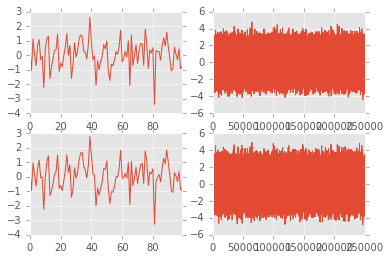

In [4]:
serie1 = p0.rvs(n_samples).ravel()
serie2 = p1.rvs(n_samples).ravel()
plt.figure(1)
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [5]:
from carl.learning import make_parameterized_classification
n_samples_points = 10
samples_set = []

parameters_points = np.linspace(0.1, 0.9, n_samples_points)
n_samples = 1000000 // n_samples_points

for k in range(n_samples_points):
    shared_alpha.set_value(parameters_points[k])
    x0 = p0.rvs(n_samples // 2, random_state = 1234)
    x1 = p1.rvs(n_samples // 2, random_state = 1234)
    x = np.vstack((x0,x1))
    y = np.zeros(n_samples)
    y[len(x0):] = 1
    samples_set.append((x,y))

In [6]:
print(samples_set[-1])

(array([[ 0.47143516],
       [-0.76668405],
       [ 0.74269133],
       ..., 
       [ 1.38289174],
       [-0.45843198],
       [-0.85507513]]), array([ 0.,  0.,  0., ...,  1.,  1.,  1.]))


In [7]:
import pdb
max_len = 2
series_set = []

for (X,y) in samples_set:
    X0_serie = []
    y0_serie = []
    X1_serie = []
    y1_serie = []

    X0 = X[y == 0]
    X1 = X[y == 1]
    for i in xrange(X0.shape[0]-max_len+1):
        # ensure that is from same time serie
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])

    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)
    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    series_set.append((X_serie, y_serie))


In [8]:
print(series_set[0][0].shape)

(99998, 2, 1)


In [9]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def scheduler(epoch):
    if (epoch + 1) % 25 == 0:
        lr_val = model.optimizer.lr.get_value()
        model.optimizer.lr.set_value(lr_val*0.5)
    return float(model.optimizer.lr.get_value())

sgd = SGD(lr=0.01, clipnorm = 40.)

classifiers = []
from keras_wrapper import KerasClassifier
lr_schedule = LearningRateScheduler(scheduler)

for k,(X_serie,y_serie) in enumerate(series_set):
    print ('Training classifier {0}'.format(k))
    model = Sequential()
    model.add(SimpleRNN(10,input_shape=(max_len,1)))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(1,activation='tanh'))

    #model.compile(loss='mean_squared_error', optimizer='rmsprop')

    clf = KerasClassifier(model=model, loss='mean_squared_error', optimizer=sgd, nb_epoch=15, verbose=2)
    #clf = make_pipeline(StandardScaler(),as_classifier(clf))

    clf.fit(X=X_serie, y=y_serie)
    classifiers.append(clf)
    #clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Training classifier 0
Epoch 1/15
0s - loss: 0.2821
Epoch 2/15
0s - loss: 0.2537
Epoch 3/15
0s - loss: 0.2518
Epoch 4/15
0s - loss: 0.2512
Epoch 5/15
0s - loss: 0.2506
Epoch 6/15
0s - loss: 0.2505
Epoch 7/15
0s - loss: 0.2504
Epoch 8/15
0s - loss: 0.2503
Epoch 9/15
0s - loss: 0.2501
Epoch 10/15
0s - loss: 0.2502
Epoch 11/15
0s - loss: 0.2502
Epoch 12/15
0s - loss: 0.2502
Epoch 13/15
0s - loss: 0.2500
Epoch 14/15
0s - loss: 0.2500
Epoch 15/15
0s - loss: 0.2499
Training classifier 1
Epoch 1/15
0s - loss: 0.2690
Epoch 2/15
0s - loss: 0.2550
Epoch 3/15
0s - loss: 0.2525
Epoch 4/15
0s - loss: 0.2514
Epoch 5/15
0s - loss: 0.2510
Epoch 6/15
0s - loss: 0.2508
Epoch 7/15
0s - loss: 0.2507
Epoch 8/15
0s - loss: 0.2505
Epoch 9/15
1s - loss: 0.2506
Epoch 10/15
1s - loss: 0.2503
Epoch 11/15
0s - loss: 0.2504
Epoch 12/15
1s - loss: 0.2503
Epoch 13/15
0s - loss: 0.2503
Epoch 14/15
0s - loss: 0.2502
Epoch 15/15
0s - loss: 0.2503
Training classifier 2
Epoch 1/15
0s - loss: 0.2805
Epoch 2/15
0s - loss: 0

Using Theano backend.
/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [13]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
ratios = []

for k,(X_serie, y_serie) in enumerate(series_set):
    # Fit ratio
    clf = classifiers[k]
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    ratio.fit(X_serie, y_serie)

    # Evaluate log-likelihood ratio
    X_true_ = X_true

    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)

    r = ratio.predict(X_true_serie, log=True)
    print r[np.isfinite(r)].shape
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
    ratios.append(value)

(14998,)
(14998,)
(14998,)
(14998,)
(14998,)
(14998,)
(14998,)
(14998,)
(14998,)
(14998,)


[-0.03021949061915781, -0.012415218986200195, -0.021069228563265499, -0.0101462810131304, -0.00052652717388833781, 0.012307708469451195, 0.0072631702571533717, 0.080072193157509408, 0.06974845334408325, 0.42763987048001278]


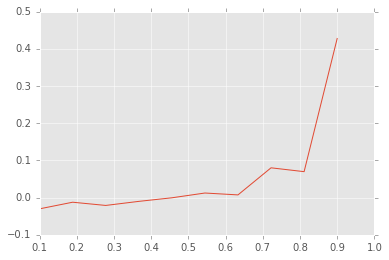

In [14]:
plt.plot(parameters_points, np.array(ratios))
print ratios

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model